In [56]:
import sys
import os
import copy
import matplotlib.pyplot as plt
import pyart
import numpy as np
sys.path.append("../")

In [36]:
from NuistRadar.io.auto_io import radar_io 
file_sa = r"D:\data\Z_RADR_I_Z9250_20150601000600_O_DOR_SA_CAP.bin.bz2"
radar_obj = radar_io(file_sa)            #自动匹配数据格式

In [37]:
NRadar = radar_obj.ToNuistRadar()        #转化成Nuist雷达的数据格式
PyartRadar = radar_obj.ToPyartRadar()    #转化成Pyart雷达的数据格式


In [38]:
NRadar.scan_info                        #返回雷达的扫描信息

<xarray.Dataset>
Dimensions:            (sweep: 9)
Coordinates:
  * sweep              (sweep) int32 0 1 2 3 4 5 6 7 8
Data variables:
    latitude           float64 32.19
    longitude          float64 118.7
    altitude           float64 138.8
    scan_type          <U3 'ppi'
    frequency          float64 2.765
    nyquist_velocity   (sweep) float64 26.55 26.55 26.55 ... 30.95 30.95 30.95
    unambiguous_range  (sweep) float64 148.0 148.0 148.0 ... 127.0 127.0 127.0
    rays_per_sweep     (sweep) int64 367 367 372 372 372 369 365 363 361
    fixed_angle        (sweep) float64 0.5 1.45 2.4 3.35 4.3 6.0 9.0 14.6 19.5

In [45]:
latitude = NRadar.scan_info['latitude'].values
longitude = NRadar.scan_info['longitude'].values
print(latitude,longitude)

32.19 118.7


In [59]:
NRadar.fields[1]

<xarray.Dataset>
Dimensions:    (range: 920, time: 367)
Coordinates:
    azimuth    (time) float64 299.8 300.7 301.6 302.6 ... 298.1 299.0 300.0
    elevation  (time) float64 1.406 1.406 1.406 1.406 ... 1.406 1.406 1.406
  * range      (range) float64 250.0 500.0 750.0 ... 2.295e+05 2.298e+05 2.3e+05
  * time       (time) datetime64[ns] 2015-06-01T00:07:55.953000 ... 2015-06-01T00:08:27.759000
Data variables:
    dBZ        (time, range) float32 nan nan nan -2.5 -2.5 ... nan nan nan nan
    V          (time, range) float64 nan nan nan nan nan ... nan nan nan nan nan
    W          (time, range) float64 nan nan nan nan nan ... nan nan nan nan nan

In [25]:
NRadar.fields[0]['time'].values

array(['2015-06-01T00:06:46.398000000', '2015-06-01T00:06:46.485000000',
       '2015-06-01T00:06:46.571000000', '2015-06-01T00:06:46.658000000',
       '2015-06-01T00:06:46.745000000', '2015-06-01T00:06:46.832000000',
       '2015-06-01T00:06:46.919000000', '2015-06-01T00:06:47.006000000',
       '2015-06-01T00:06:47.094000000', '2015-06-01T00:06:47.180000000',
       '2015-06-01T00:06:47.267000000', '2015-06-01T00:06:47.353000000',
       '2015-06-01T00:06:47.440000000', '2015-06-01T00:06:47.527000000',
       '2015-06-01T00:06:47.614000000', '2015-06-01T00:06:47.703000000',
       '2015-06-01T00:06:47.788000000', '2015-06-01T00:06:47.875000000',
       '2015-06-01T00:06:47.962000000', '2015-06-01T00:06:48.049000000',
       '2015-06-01T00:06:48.136000000', '2015-06-01T00:06:48.222000000',
       '2015-06-01T00:06:48.309000000', '2015-06-01T00:06:48.396000000',
       '2015-06-01T00:06:48.484000000', '2015-06-01T00:06:48.570000000',
       '2015-06-01T00:06:48.662000000', '2015-06-01

In [47]:
PyartRadar.time

{'units': 'seconds since 2015-06-01T00:06:46Z',
 'standard_name': 'time',
 'long_name': 'time_in_seconds_since_volume_start',
 'calendar': 'gregorian',
 'comment': 'Coordinate variable for time. Time at the center of each ray, in fractional seconds since the global variable time_coverage_start',
 'data': array([  0.398,   0.485,   0.571, ..., 329.958, 330.028, 330.097],
       dtype=float32)}

C:\Users\vanyar\Anaconda3\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


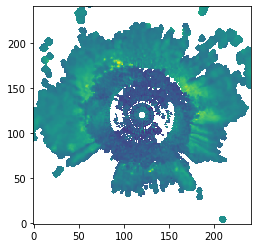

In [58]:
PyartRadar.fields['reflectivity']['data'][:, -10:] = np.ma.masked
# exclude masked gates from the gridding
gatefilter = pyart.filters.GateFilter(PyartRadar)
gatefilter.exclude_transition()
gatefilter.exclude_masked('reflectivity')

# perform Cartesian mapping, limit to the reflectivity field.
grid = pyart.map.grid_from_radars(
    (PyartRadar,), gatefilters=(gatefilter, ),
    grid_shape=(1, 241, 241),
    grid_limits=((2000, 2000), (-123000.0, 123000.0), (-123000.0, 123000.0)),
    fields=['reflectivity'])

# create the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(grid.fields['reflectivity']['data'][0], origin='lower')
plt.show()

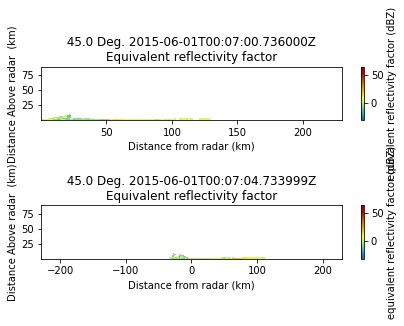

In [61]:
xsect = pyart.util.cross_section_ppi(PyartRadar, [45, 90])

display = pyart.graph.RadarDisplay(xsect)
fig = plt.figure()
ax = fig.add_subplot(211)
display.plot('reflectivity', 0, vmin=-32, vmax=64.)
ax = fig.add_subplot(212)
display.plot('reflectivity', 1, vmin=-32, vmax=64.)
plt.tight_layout()
plt.show()